# Machine Learning Models

After analyze the data, understood the features impact on the target variable and filtered the most significant correlations we will prepare the data and train our Machine Learning models. The goal of this step is using pipeline, training different kind of ML models and choose our best model with the best metrics for our case, that is, Predicting the invoice in Game Market in the Russia.

We will focus in PS3 Games that is the greater source, but the another 2 main category would will pass for the same processes in this steps, so to not be so exhaustive we will see only one category. :D

In [1]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.patches as mpatches
import datetime

In [2]:
df_PS3Games = pd.read_csv('df_PS3Games.csv', sep = ',')
df_PS3Games.head()

,Date,Price,Freq,Invoice,Dayofweek,GDP,IMOEX,RubinDolar
0,2013-01-01,1479.487115,128,189374.350769,1,2.297128e+12,1526.98,0.0327
1,2013-01-02,1561.694303,525,819889.508928,2,2.297498e+12,1526.98,0.0327
2,2013-01-03,1483.195423,443,657055.572183,3,2.297862e+12,1526.98,0.0331
3,2013-01-04,1532.475859,399,611457.867576,4,2.298220e+12,1526.98,0.0330
4,2013-01-05,1490.351956,399,594650.430267,5,2.298573e+12,1526.98,0.0330


Splitting the dataset 80/20, that is, 80% to training and 20% to test, we will use the train_test_split of the scikit learn.

In [3]:
X = df_PS3Games[['Dayofweek','GDP','IMOEX','RubinDolar']]
y = df_PS3Games['Invoice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0)

It is very important check the shape after the splitting, we can avoid a lot of errors with this.

In [4]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((728, 4), (183, 4), (728,), (183,))

In [5]:
range = df_PS3Games.Date
df=pd.DataFrame(index = df_PS3Games.Date)

## Linear Regression

Using the pipeline to a good practice, we will use 2 transformers and an estimator. The transformers is used to modify the data to a better format to the model, in this case we will use the StandardScaler to normalize the independent variables, such that each feature doesn't have a different impact to our model due the scale, the second transformer is Principal Component Analysis, a technique to identify the principal component in our independent dataset in order to simplify the understanding to our Machine Learning Model. The Estimator is the model, in this case is the LinearRegression that will try to predict the test split.

In [6]:
regr = LinearRegression()
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA()),
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [7]:
y_test.shape, ypipe.shape

((183,), (183,))

In [8]:
y_train = y_train.reset_index()
del y_train['index']
y_trainValue = y_train['Invoice'].values
y_test = y_test.reset_index()
del y_test['index']
y_testValue = y_test['Invoice'].values

In [9]:
predictions_series = pd.Series(ypipe, index=df.index[728:])
train_series = pd.Series(y_trainValue, index=df.index[:728])
test_series = pd.Series(y_testValue, index=df.index[728:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)

C:\Users\Anthony\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


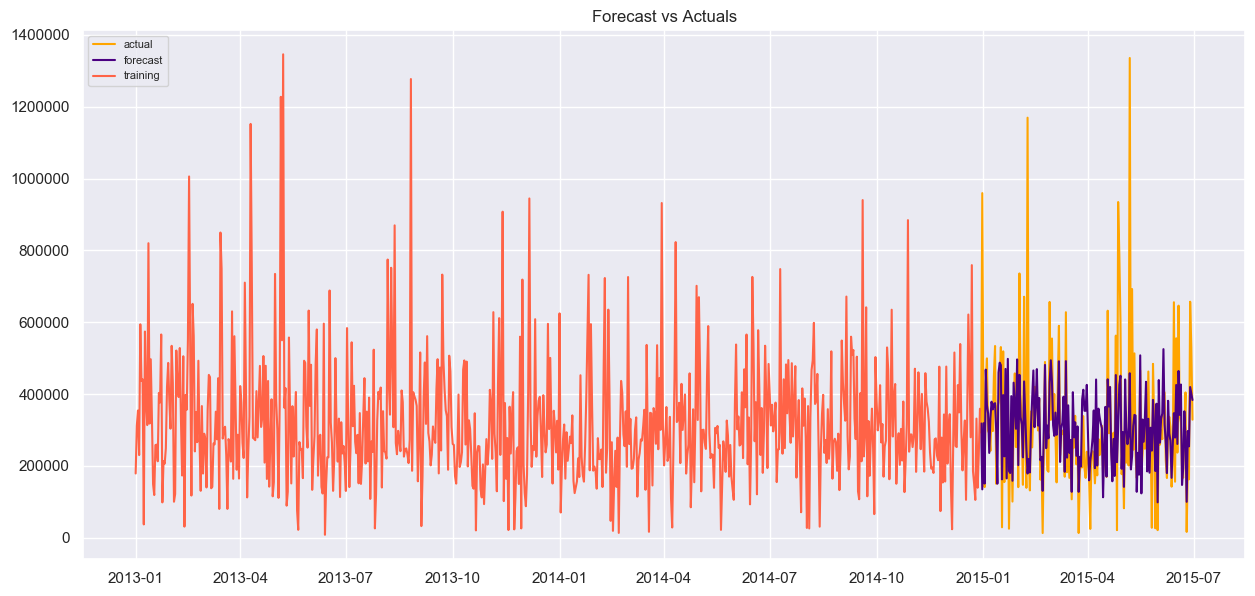

In [10]:
plt.figure(figsize=(15,7), dpi=100)
plt.plot(test_series, label='actual',color = 'orange')
plt.plot(predictions_series, label='forecast',color='indigo')
plt.plot(train_series, label='training', color='tomato' )
#plt.fill_between(train_labels.index, train_labels, test_labels, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Lets get a zoom in to see more details.

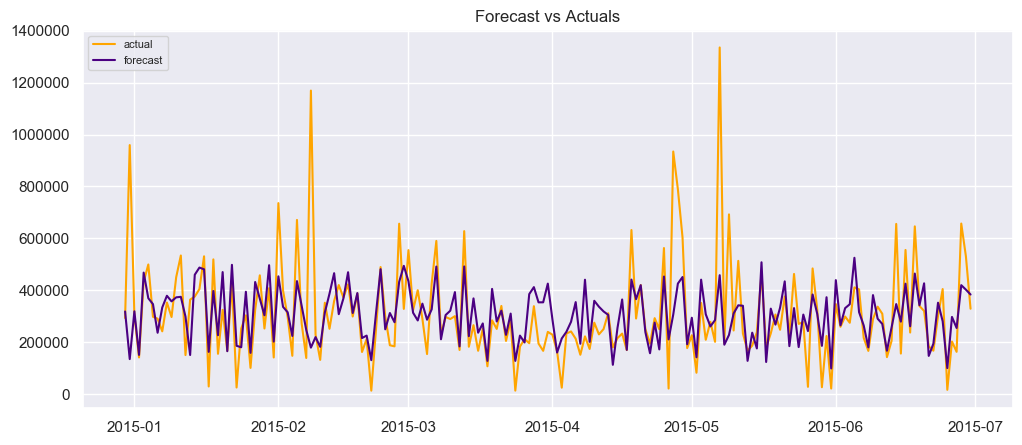

In [12]:
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_labels, label='training')
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'indigo')
#plt.fill_between(train_labels.index, train_labels, test_labels, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Creating a function to show the regression metrics

In [13]:
def forecast_accuracy(predictions, test_labels):
    forecast = predictions
    actual = test_labels
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions_series, test_series)

{'mape': 0.6380909203453738,
 'me': -3907.405518970814,
 'mae': 100377.1836757322,
 'mpe': 0.4582017511267137,
 'rmse': 164617.91103023262,
 'corr': 0.5288066707321127,
 'minmax': 0.2610714053024302}

We have a difficult to identify the better model using the MSE and RMSE, it's necessary to take a little time understanding metrics vary by model units. The easiest way to compare the models is with the metric called Coefficient of Determination (R²), it is a scale-free metric, that is R², has an interval -inf to 1, where 1 is the best model and a negative R² is the worse than predict the mean.

With the Linear Regression we get a Pearson correlation of 53%, it's a moderate relationship, I'm a little excited to this, but let's see the another models.

## Random Forest Regression

Applying the same pre-steps to the RF model

In [14]:
df_PS3Games = pd.read_csv('df_PS3Games.csv', sep = ',')
X = df_PS3Games[['Dayofweek','GDP','IMOEX','RubinDolar']]
y = df_PS3Games['Invoice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0)
range = df_PS3Games.Date
df=pd.DataFrame(index = df_PS3Games.Date)

After the split let's put it in the pipeline, with the same transformers just chance the model, of course.

In [15]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA()),
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [16]:
predictions_series = pd.Series(ypipe, index=df.index[728:])
train_series = pd.Series(y_trainValue, index=df.index[:728])
test_series = pd.Series(y_testValue, index=df.index[728:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)

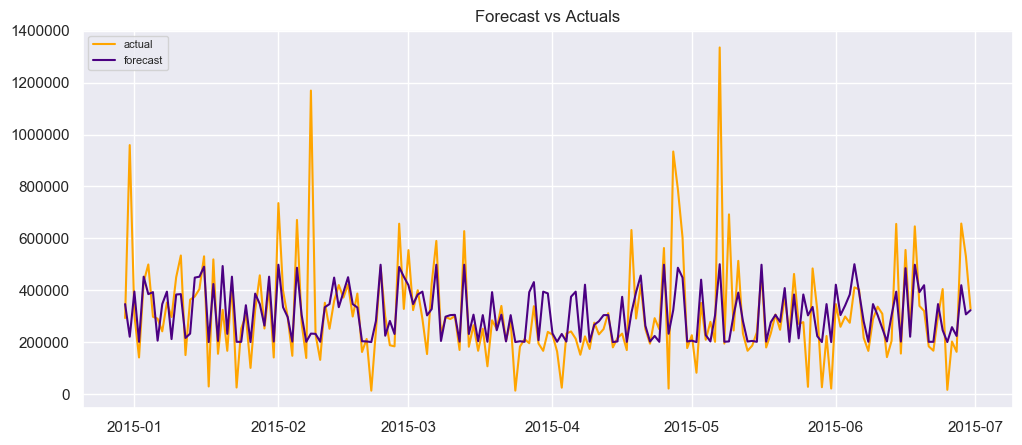

In [17]:
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_labels, label='training')
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'indigo')
#plt.fill_between(train_labels.index, train_labels, test_labels, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
# Metrics
forecast_accuracy(predictions_series, test_series)

{'mape': 0.7722359273043331,
 'me': -1496.1138627774365,
 'mae': 95585.61212025365,
 'mpe': 0.6100347851145763,
 'rmse': 158111.35418950065,
 'corr': 0.5842659399650348,
 'minmax': 0.24744390833388796}

With the Random Forest it was most promising that the Linear Regression Model, remember that I didn't care about the hyperparameter yet. So 58% it's really promising.

## Ridge Regression

In [19]:
df_PS3Games = pd.read_csv('df_PS3Games.csv', sep = ',')
X = df_PS3Games[['Dayofweek','GDP','IMOEX','RubinDolar']]
y = df_PS3Games['Invoice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0)
range = df_PS3Games.Date
df=pd.DataFrame(index = df_PS3Games.Date)

In [20]:
regr = Ridge()
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA()),
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [23]:
predictions_series = pd.Series(ypipe, index=df.index[728:])
train_series = pd.Series(y_trainValue, index=df.index[:728])
test_series = pd.Series(y_testValue, index=df.index[728:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)

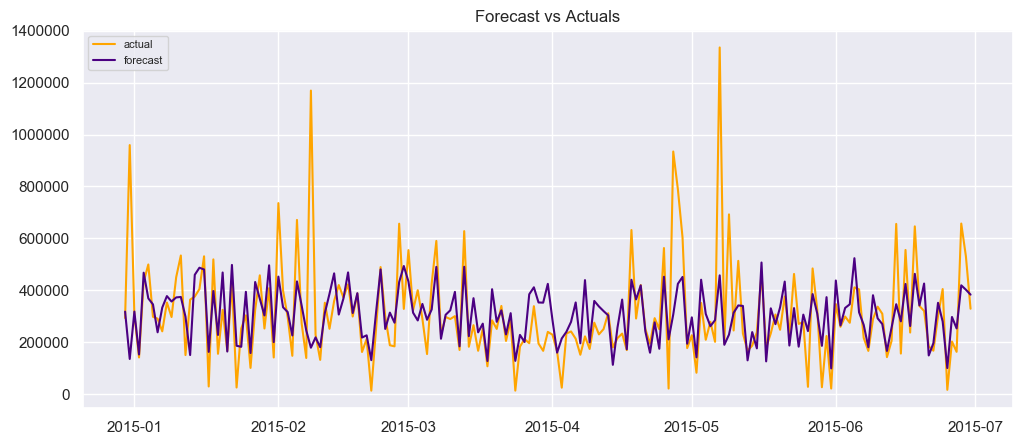

In [24]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'indigo')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
# Metrics
forecast_accuracy(predictions_series, test_series)

{'mape': 0.6381459805411225,
 'me': -3858.977528958094,
 'mae': 100357.56270739113,
 'mpe': 0.459055856513518,
 'rmse': 164622.92572968273,
 'corr': 0.528736106086778,
 'minmax': 0.2609391399401665}

Comparing the R² of the regression models we can notice that the Coefficient of Determination of Random Forest Regressor Model is the greater than others. It's very promising, so we will try to optmize the models in the next step by Grid Search Optimization.

| Linear  | Random Forest| Ridge |
|------|------|------|
|   0.5288  |0.5842|  0.5287   |